In [3]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import string
import re

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from functions_jonne import plot_images

pd.options.mode.chained_assignment = None  # default='warn'

os.chdir('./output')

# find images from newest folder of segmentation

In [2]:
def get_unique_plates(file_paths):
    unique_plates = set()
    for path in file_paths:
        acqID = path.split('/')[4]
        unique_plates.add(acqID)
    return sorted(list(unique_plates))

In [19]:
image_folder = '/share/data/cellprofiler/automation/results/P10355*/'

all_images = sorted(glob.glob(f"{image_folder}*/*/*/obj*/*"))
filtered_images = [x for x in all_images if 'thumb' not in x]
print(len(filtered_images))

23940


In [20]:
file_list = pd.DataFrame(filtered_images, columns=['File Names'])
file_list.to_csv("experiment_image_filepaths.csv")

In [22]:
meta = pd.read_csv('../metadata/LABDESIGN_metadata_SSS-A549-v2.csv', low_memory=False, sep=",") # change for each exp
meta["Metadata_CellLine"]    = "A549-ACE2"
meta["Metadata_CellDensity"] = 2500
meta = meta.rename(columns={
                     "barcode": "Metadata_plate_map_name",
                     "batch_id": "Metadata_cmpdName",
                     "well_id": "Metadata_Well",
                     "cell_line": "Metadata_CellLine",
                     "cmpd_conc": "Metadata_cmpdConc",
                     "cells_per_well": "Metadata_CellDensity"},
            errors="raise")

meta["Metadata_Site"] = 4
meta

Metadata_plate_map_name  layout_id Metadata_Well solvent  stock_conc  \
0                    P103554        NaN           A02    DMSO         0.1   
1                    P103554        NaN           A03    DMSO        10.0   
2                    P103554        NaN           A04    DMSO        10.0   
3                    P103554        NaN           A05    DMSO         0.1   
4                    P103554        NaN           A06    DMSO         0.1   
...                      ...        ...           ...     ...         ...   
8343                 P103588        NaN           P19    DMSO       100.0   
8344                 P103588        NaN           P20    DMSO       100.0   
8345                 P103588        NaN           P21    DMSO       100.0   
8346                 P103588        NaN           P22    DMSO       100.0   
8347                 P103588        NaN           P23    DMSO       100.0   

     stock_conc_unit pert_type Metadata_cmpdName  cmpd_vol cmpd_vol_unit  ...  \
0                 mM       trt         BJ1894548      90.0            nL  ...   
1                 mM       trt         BJ1894765      30.0            nL  ...   
2                 mM       trt         BJ1896470      30.0            nL  ...   
3                 mM       trt         BJ1897228      30.0            nL  ...   
4                 mM       trt         BJ1896003      90.0            nL  ...   
...              ...       ...               ...       ...           ...  ...   
8343            perc    negcon              DMSO      90.0            nL  ...   
8344            perc    negcon              DMSO      90.0            nL  ...   
8345            perc    negcon              DMSO      90.0            nL  ...   
8346            perc    negcon              DMSO      90.0            nL  ...   
8347            perc    negcon              DMSO      90.0            nL  ...   

      plate_size plate_type      seeded treatment treatment_units     painted  \
0            384         PE  2023-10-16        24               h  2023-10-18   
1            384         PE  2023-10-16        24               h  2023-10-18   
2            384         PE  2023-10-16        24               h  2023-10-18   
3            384         PE  2023-10-16        24               h  2023-10-18   
4            384         PE  2023-10-16        24               h  2023-10-18   
...          ...        ...         ...       ...             ...         ...   
8343         384         PE  2023-10-16        24               h  2023-10-18   
8344         384         PE  2023-10-16        24               h  2023-10-18   
8345         384         PE  2023-10-16        24               h  2023-10-18   
8346         384         PE  2023-10-16        24               h  2023-10-18   
8347         384         PE  2023-10-16        24               h  2023-10-18   

      painted_type Metadata_CellLine Metadata_CellDensity  Metadata_Site  
0      semi-manual         A549-ACE2                 2500              4  
1      semi-manual         A549-ACE2                 2500              4  
2      semi-manual         A549-ACE2                 2500              4  
3      semi-manual         A549-ACE2                 2500              4  
4      semi-manual         A549-ACE2                 2500              4  
...            ...               ...                  ...            ...  
8343   semi-manual         A549-ACE2                 2500              4  
8344   semi-manual         A549-ACE2                 2500              4  
8345   semi-manual         A549-ACE2                 2500              4  
8346   semi-manual         A549-ACE2                 2500              4  
8347   semi-manual         A549-ACE2                 2500              4  

[8348 rows x 26 columns]

In [23]:
# Generate regex pattern for each image in df
meta['pattern'] = meta.apply(
    lambda row: f'.*{row["Metadata_plate_map_name"]}_{row["Metadata_Well"]}_site{row["Metadata_Site"]}.png',
    axis=1
)

# Find matching pathnames for images
matching_pathnames = []

for _, row in meta.iterrows():
    regex = row['pattern']
    matching_paths = [p for p in filtered_images if re.match(regex, p)]
    matching_pathnames.append(matching_paths[0] if matching_paths else None)

meta['Filenames'] = matching_pathnames
meta = meta.dropna(subset=['Filenames'])
meta.head(2)

Metadata_plate_map_name  layout_id Metadata_Well solvent  stock_conc  \
0                 P103554        NaN           A02    DMSO         0.1   
1                 P103554        NaN           A03    DMSO        10.0   

  stock_conc_unit pert_type Metadata_cmpdName  cmpd_vol cmpd_vol_unit  ...  \
0              mM       trt         BJ1894548      90.0            nL  ...   
1              mM       trt         BJ1894765      30.0            nL  ...   

       seeded treatment  treatment_units     painted painted_type  \
0  2023-10-16        24                h  2023-10-18  semi-manual   
1  2023-10-16        24                h  2023-10-18  semi-manual   

   Metadata_CellLine  Metadata_CellDensity Metadata_Site  \
0          A549-ACE2                  2500             4   
1          A549-ACE2                  2500             4   

                   pattern                                          Filenames  
0  .*P103554_A02_site4.png  /share/data/cellprofiler/automation/results/P1...  
1  .*P103554_A03_site4.png  /share/data/cellprofiler/automation/results/P1...  

[2 rows x 28 columns]

In [24]:
meta['ImageID'] =  meta['Metadata_plate_map_name'] + "-" + meta['Metadata_Well'] + "-" +  meta['Metadata_cmpdName'] 
meta.to_csv("images_pathnames.csv", index=False)

# show images

In [25]:
# Load labels

labels_path = "/home/jovyan/jonne/Feature_Analysis/2023/Feature_Analysis_SSS-val-A549-v2-JR/output/images_pathnames.csv"
df_labels = pd.read_csv(labels_path)

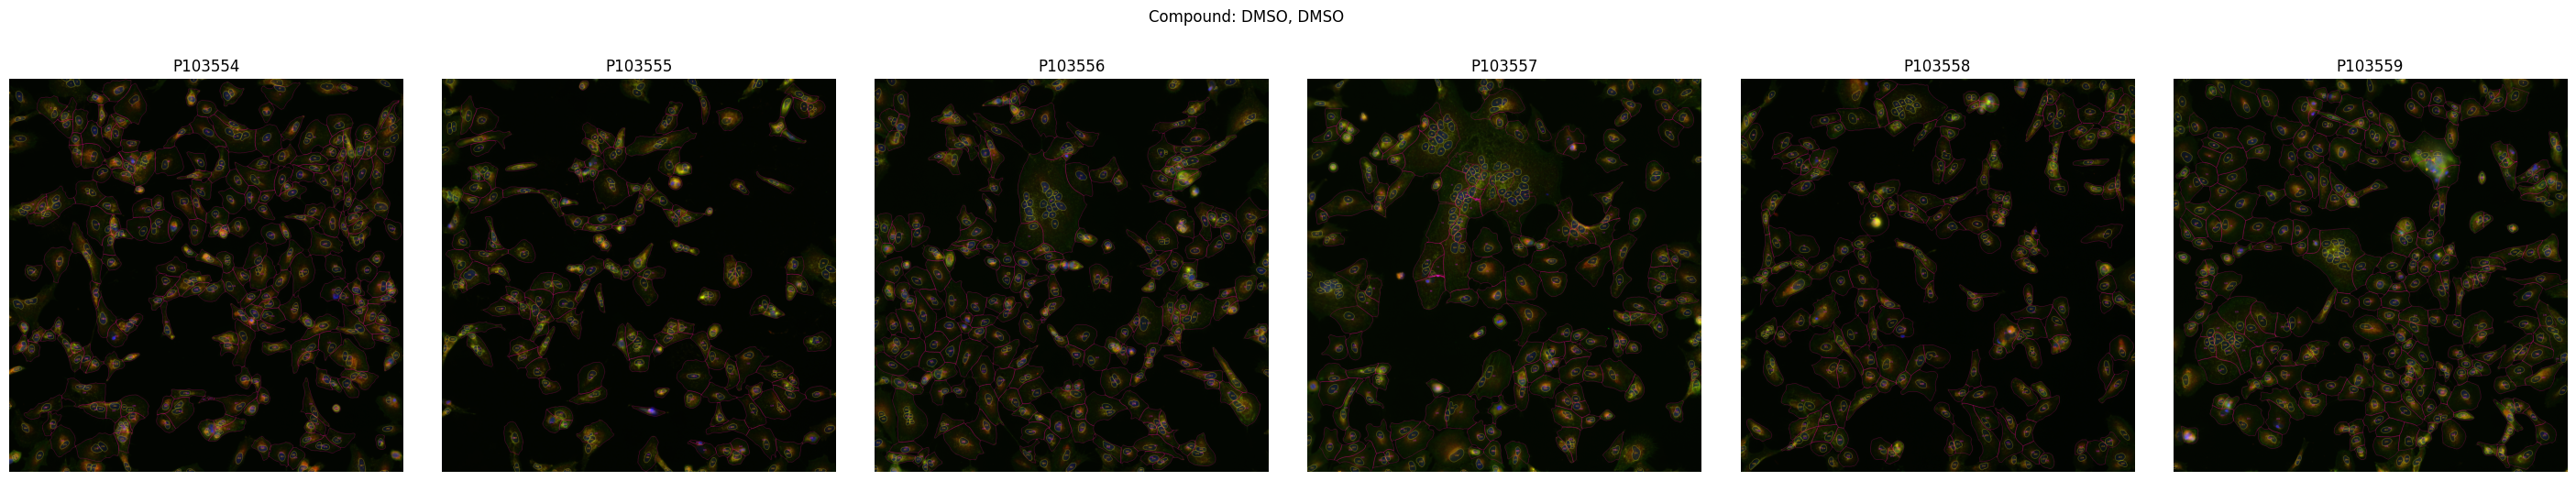

In [26]:
selected_condition = 'DMSO'

df_plot = df_labels.loc[df_labels["Metadata_cmpdName"] == selected_condition]
plot_images(df_plot, selected_condition)

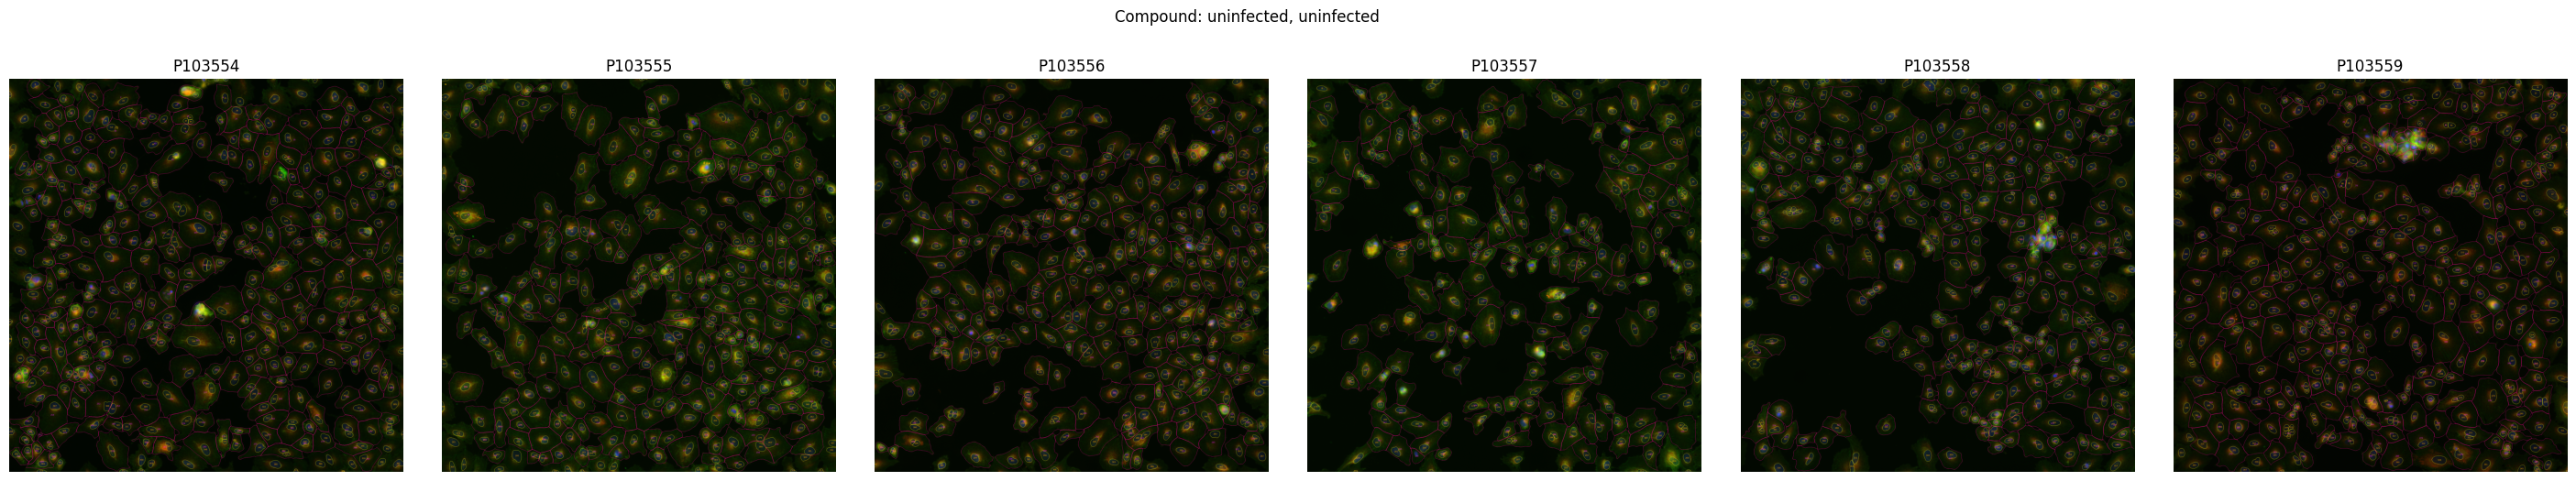

In [27]:
selected_condition = 'uninfected'

df_plot = df_labels.loc[df_labels["Metadata_cmpdName"] == selected_condition]
plot_images(df_plot, selected_condition)